In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import importlib
plt.style.use('dark_background')

In [2]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 4, 2

In [3]:
sys.path.insert(0, '../seqm') 

In [4]:
# setting path
import model_pipe
import models
import generators
import dataset     
import post_process      

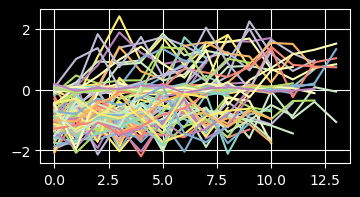

,y1,idx
2000-01-03,-0.478570,0.0
2000-01-04,-1.415525,0.0
2000-01-05,-1.338616,0.0
2000-01-06,-0.001711,0.0
2000-01-07,0.008213,0.0
...,...,...
2003-08-05,-0.945950,99.0
2003-08-06,-0.638693,99.0
2003-08-07,-1.253931,99.0
2003-08-08,-0.135064,99.0


In [24]:
# multisequence HMM - useful to model behaviour in a cyclic way
# simulate and fit
A=np.array([
            [0.9,0.1,0],
            [0,0.9,0.1],
            [0,0,1.]
        ]) # state transition

P=np.array([0.7,0.3,0]) # initial state distribution

means=[
        np.array([-1]),
        np.array([0.]),
        np.array([1])
    ] # let the means be different from zero 

# list of covariance matrices (for each mixture)
covs=[
    np.array([[0.25]]),
    np.array([[0.01]]),
    np.array([[0.25]])
]

k=100
n_min=5
n_max=15
o=[]
msidx=[]
for i in range(k):
    n=np.random.randint(n_min,n_max)
    x_,z_=generators.simulate_hmm(n,A,P,means,covs)
    o.append(x_)
    msidx.append(i*np.ones(x_.shape[0],dtype=int)[:,None])
    plt.plot(x_)
plt.grid(True)
plt.show()

y=np.vstack(o)  
msidx=np.vstack(msidx)

dates=pd.date_range('2000-01-01',periods=y.shape[0],freq='B')
data=pd.DataFrame(np.hstack((y,msidx)),columns=['y1','idx'],index=dates)
data

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 25.64it/s]


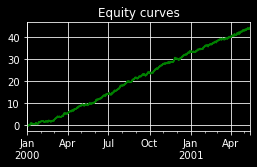

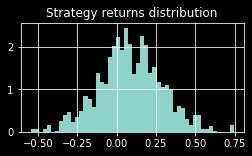

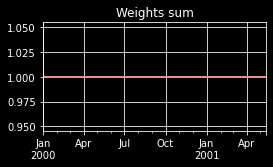

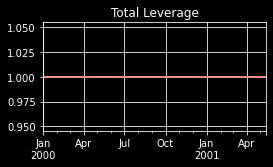

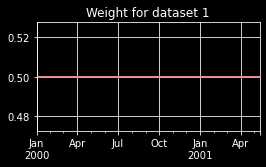

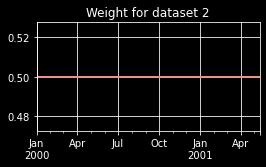

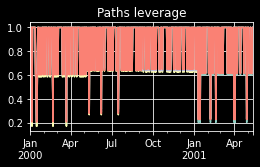

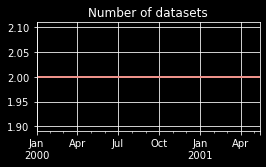


** ACCEPT STRATEGY **


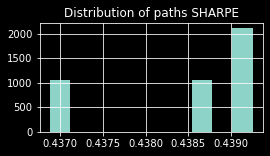

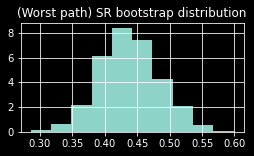


** PERFORMANCE SUMMARY **

Return:  0.08874082148382689
Standard deviation:  0.20238748340817656
Sharpe:  0.4384699092525092



In [5]:
# data now contains observed states, for example model for different weekdays
phi=np.array([0.8,0.2])
means=[
        np.array([0.1]),
        np.array([-0.1])
    ] # let the means be different from zero 

# list of covariance matrices (for each mixture)
covs=[
    np.array([[0.1]]),
    np.array([[0.5]])
]
# number of data points to generate
n=500 

x1,z1=generators.simulate_mvgmm(n,phi,means,covs)
x2,z2=generators.simulate_mvgmm(n,phi,means,covs)
dates=pd.date_range('2000-01-01',periods=x1.shape[0],freq='D')
data1=pd.DataFrame(np.hstack((x1,z1[:,None])),columns=['y1','z'],index=dates)
data2=pd.DataFrame(np.hstack((x2,z2[:,None])),columns=['y1','z'],index=dates)

dataset_obj=dataset.Dataset({'dataset 1':data1,'dataset 2':data2})	

# create model
model=models.StateGaussian(n_gibbs=None,f_burn=0.1,max_k=0.25,min_points=10)
model_pipes=model_pipe.ModelPipes(model)
for key in dataset_obj.keys():
    model_pipe_ = model_pipe.ModelPipe()
    model_pipes[key] = model_pipe_

paths=dataset_obj.cvbt(
                model_pipes, 
                k_folds=4, 
                seq_path=False, 
                start_fold=0, 
                n_paths=4, 
                burn_fraction=0.1, 
                min_burn_points=3, 
                share_model=True, 
                view_models=False
                )
post_process.portfolio_post_process(paths)





100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 21.04it/s]


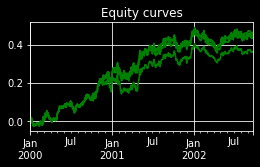

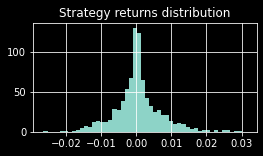

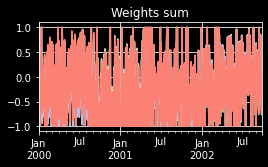

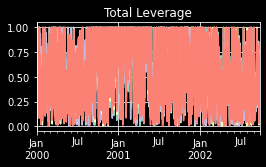


** REJECT STRATEGY **


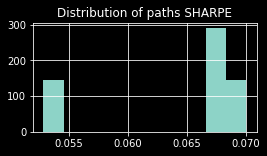

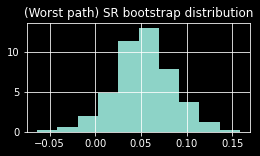


** PERFORMANCE SUMMARY **

Return:  0.0004327165802425018
Standard deviation:  0.00670478687003431
Sharpe:  0.0645384541865814



In [9]:
# Conditional Gaussian/Mixture
# data now contains observed states, for example model for different weekdays
phi=np.array([0.8,0.2])
means=[
        np.array([0.1]),
        np.array([-0.1])
    ] # let the means be different from zero 
# list of covariance matrices (for each mixture)
covs=[
    np.array([[0.1]]),
    np.array([[0.5]])
]
# number of data points to generate
n=500 
data=generators.linear(n=1000,a=0,b=0.1,start_date='2000-01-01')

dataset_obj=dataset.Dataset({'dataset 1':data})	
# create model
model=models.ConditionalGaussian(n_gibbs=None,kelly_std=2,max_w=1)
model_pipes=model_pipe.ModelPipes(None)
for key in dataset_obj.keys():
    model=models.ConditionalGaussian(n_gibbs=None,kelly_std=2,max_w=1)
    model_pipe_ = model_pipe.ModelPipe(model = model)
    model_pipes[key] = model_pipe_

paths=dataset_obj.cvbt(
                model_pipes, 
                k_folds=4, 
                seq_path=False, 
                start_fold=0, 
                n_paths=4, 
                burn_fraction=0.1, 
                min_burn_points=3, 
                share_model=True, 
                view_models=False
                )
post_process.post_process(paths)
    

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:17<00:00,  4.40s/it]


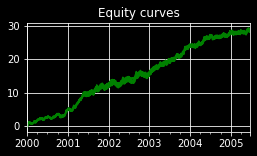

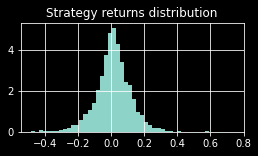

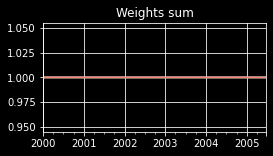

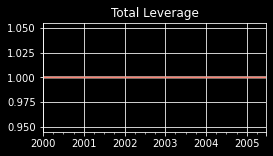

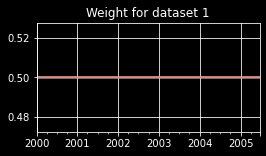

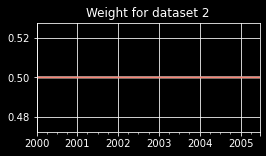

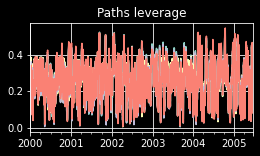

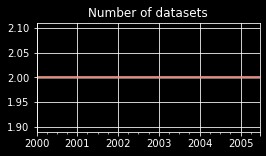


** ACCEPT STRATEGY **


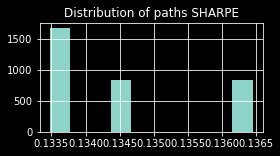

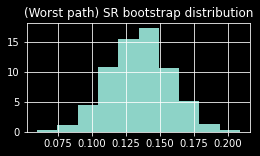


** PERFORMANCE SUMMARY **

Return:  0.014408021915861303
Standard deviation:  0.10713211357779422
Sharpe:  0.1344883568025463



In [10]:
# HMM
# simple HMM 
# simulate and fit
A=np.array([
            [0.9,0.1],
            [0.1,0.9]
        ]) # state transition

P=np.array([0.5,0.5]) # initial state distribution

means=[
        np.array([0.1]),
        np.array([-0.1])
    ] # let the means be different from zero 

# list of covariance matrices (for each mixture)
covs=[
    np.array([[0.1]]),
    np.array([[0.5]])
]
# number of data points to generate
n=2000 
x1,z=generators.simulate_hmm(n,A,P,means,covs)
x2,z=generators.simulate_hmm(n,A,P,means,covs)

dates=pd.date_range('2000-01-01',periods=n,freq='D')
data1=pd.DataFrame(x1,columns=['y1'],index=dates)
data2=pd.DataFrame(x2,columns=['y1'],index=dates)

dataset_obj=dataset.Dataset({'dataset 1':data1, 'dataset 2':data2})	
# create model
model=models.GaussianHMM(n_states=2,n_gibbs=100,kelly_std=2,max_w=1)
model_pipes=model_pipe.ModelPipes(model)
for key in dataset_obj.keys():
    model_pipe_ = model_pipe.ModelPipe()
    model_pipes[key] = model_pipe_

paths=dataset_obj.cvbt(
                model_pipes, 
                k_folds=4, 
                seq_path=False, 
                start_fold=0, 
                n_paths=4, 
                burn_fraction=0.1, 
                min_burn_points=3, 
                share_model=True, 
                view_models=False
                )
post_process.portfolio_post_process(paths)

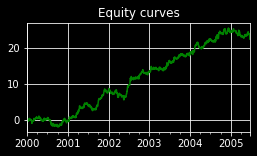

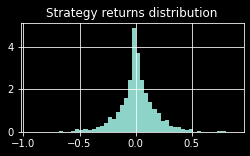

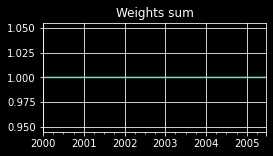

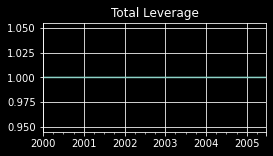

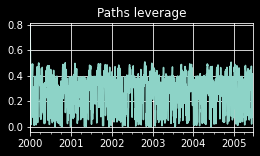

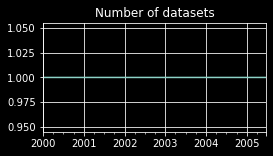


** REJECT STRATEGY **


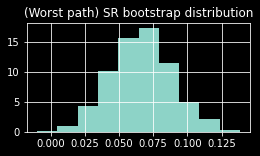


** PERFORMANCE SUMMARY **

Return:  0.011156091155474186
Standard deviation:  0.1663751079044623
Sharpe:  0.06705384775395822



In [11]:
# HMM TRAIN TEST
A=np.array([
            [0.9,0.1],
            [0.1,0.9]
        ]) # state transition

P=np.array([0.5,0.5]) # initial state distribution

means=[
        np.array([0.1]),
        np.array([-0.1])
    ] # let the means be different from zero 

# list of covariance matrices (for each mixture)
covs=[
    np.array([[0.1]]),
    np.array([[0.5]])
]
# number of data points to generate
n=2000 
x1,z=generators.simulate_hmm(n,A,P,means,covs)
x2,z=generators.simulate_hmm(n,A,P,means,covs)

dates=pd.date_range('2000-01-01',periods=n,freq='D')
data1=pd.DataFrame(x1,columns=['y1'],index=dates)
data2=pd.DataFrame(x2,columns=['y1'],index=dates)

dataset_obj_1=dataset.Dataset({'dataset 1':data1})	
# create model
model=models.GaussianHMM(n_states=2,n_gibbs=100,kelly_std=2,max_w=1)
model_pipes=model_pipe.ModelPipes(model)
for key in dataset_obj_1.keys():
    model_pipe_ = model_pipe.ModelPipe()
    model_pipes[key] = model_pipe_
model_pipes = dataset_obj_1.train(model_pipes)

dataset_obj_2 = dataset.Dataset({'dataset 1':data2})
paths = dataset_obj_2.test(model_pipes)
post_process.portfolio_post_process(paths)



In [12]:
print('RUN LIVE')
# GET THE CURRENT WEIGHTS!
out=dataset_obj_2.live(model_pipes)
print(out)

RUN LIVE
{'dataset 1': {'w': array([-0.34651917]), 'pw': 1}}
